In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

In [21]:
def theor_psd_mk_ar(f, s, A, f0, sr):
    phi = 2 * np.pi * f0 / sr
    psi = 2 * np.pi * f / sr
    denom_ft = 1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A**2 * np.exp(-2j * psi)
    return s**2 / np.abs(denom_ft) ** 2


def theor_psd_mk_arma(f, s, A, f0, sr):
    phi = 2 * np.pi * f0 / sr
    psi = 2 * np.pi * f / sr

    a = (1 - 2 * A**2 * np.cos(phi) ** 2 + A**4 * np.cos(2 * phi)) / (A**3 - A) / np.cos(phi)
    b = 0.5 * (a - 2 * A * np.cos(phi) + np.sqrt((a - 2 * A * np.cos(phi)) ** 2 - 4))
    V = -(s**2) * A * np.cos(phi) / b

    denom_ft = 1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A**2 * np.exp(-2j * psi)
    num_ft = 1 + b * np.exp(-1j * psi)
    return V * np.abs(num_ft) ** 2 / np.abs(denom_ft) ** 2


def theor_psd_mk_mar(f, s, A, f0, sr):
    phi = 2 * np.pi * f0 / sr
    psi = 2 * np.pi * f / sr

    denom_ft = 1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A**2 * np.exp(-2j * psi)
    num_ft_abs_sq = 1 - 2 * A * np.cos(phi) * np.cos(psi) + A**2
    return s**2 * num_ft_abs_sq / np.abs(denom_ft) ** 2

In [57]:
# Setup params and generate data
def complex_noise_step():
    return np.random.randn() + 1j * np.random.randn()


s_continuous, A, f0, sr = 1, 0.99, 20, 1000
s_discrete = s_continuous * np.sqrt(sr)
n_samp = 10_000
x = np.random.randn() + 1j * np.random.randn()
mk_samples = [x]
Phi = A * np.exp(1j * 2 * np.pi * f0 / sr)
for _ in range(n_samp):
    mk_samples.append(Phi * mk_samples[-1] + complex_noise_step() * s_discrete)
mk_samples = np.array(mk_samples)

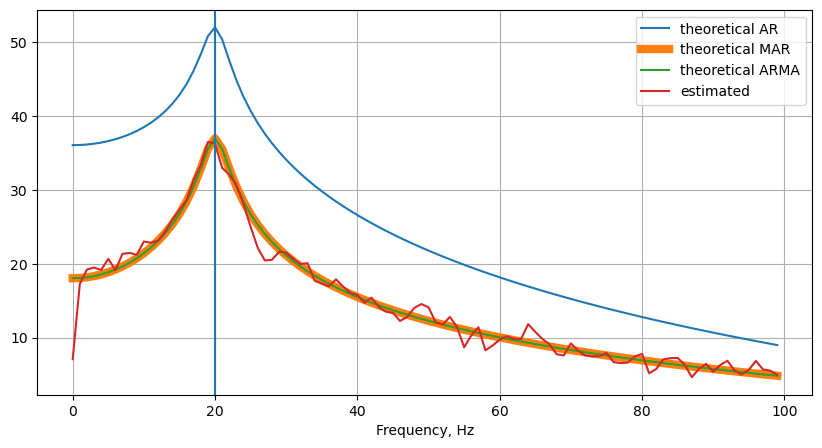

In [60]:
def to_db(arr):
    return 10 * np.log10(arr)


ff, psd_est = welch(np.real(mk_samples), fs=sr, nperseg=1000)
FREQ_LIM = 100
psd_est = np.array([p / 2 for f, p in zip(ff, psd_est) if f < FREQ_LIM])
ff = np.array([f for f in ff if f < FREQ_LIM])

psd_mar = np.array([theor_psd_mk_mar(f, s_continuous, A, f0, sr) for f in ff])
psd_ar = np.array([theor_psd_mk_ar(f, s_continuous, A, f0, sr) for f in ff])
psd_arma = np.array([theor_psd_mk_arma(f, s_continuous, A, f0, sr) for f in ff])

fig = plt.figure(figsize=(10, 5))
plt.plot(ff, to_db(psd_ar), label="theoretical AR")
plt.plot(ff, to_db(psd_mar), label="theoretical MAR", linewidth=6)
plt.plot(ff, to_db(psd_arma), label="theoretical ARMA")
plt.plot(ff, to_db(psd_est), label="estimated")

plt.axvline(x=f0)
plt.legend()
plt.xlabel("Frequency, Hz")
plt.grid()